In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 

from scipy.sparse import csr_matrix

In [2]:
DATA_DIR = "Z:/Cailab/yongjian_Dropbox/open-problems-multimodal/"

os.listdir(DATA_DIR)

['evaluation_ids.csv',
 'metadata.csv',
 'metadata_cite_day_2_donor_27678.csv',
 'sample_submission.csv',
 'test_cite_inputs.h5',
 'test_cite_inputs_day_2_donor_27678.h5',
 'test_multi_inputs.h5',
 'train_cite_inputs.h5',
 'train_cite_targets.h5',
 'train_multi_inputs.h5',
 'train_multi_targets.h5']

In [3]:
CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5") # gene
CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5") # protein
CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5") # gene

MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

### Meta data

In [4]:
df_cell_meta = pd.read_csv(CELL_METADATA) 
# NOTE: the cell type is hidden for the test set of the multiome as this can reveal information about the RNA.

df_cell_meta

,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq
...,...,...,...,...,...
281523,96a60b026659,10,31800,hidden,multiome
281524,d493e546991e,10,31800,hidden,multiome
281525,05666c99aa48,10,31800,hidden,multiome
281526,121f946642b5,10,31800,hidden,multiome


In [5]:
len(np.unique(df_cell_meta["cell_id"])) # check duplicates

281528

In [6]:
df_cell_cite = df_cell_meta[df_cell_meta.technology=="citeseq"]
df_cell_multi = df_cell_meta[df_cell_meta.technology=="multiome"]

print(df_cell_cite.shape, df_cell_multi.shape) # train_x + test_x

print(np.unique(df_cell_meta["day"]))
print(np.unique(df_cell_multi["day"]))
print(np.unique(df_cell_meta["cell_type"]))
print(np.unique(df_cell_multi["cell_type"]))

(119651, 5) (161877, 5)
[ 2  3  4  7 10]
[ 2  3  4  7 10]
['BP' 'EryP' 'HSC' 'MasP' 'MkP' 'MoP' 'NeuP' 'hidden']
['BP' 'EryP' 'HSC' 'MasP' 'MkP' 'MoP' 'NeuP' 'hidden']


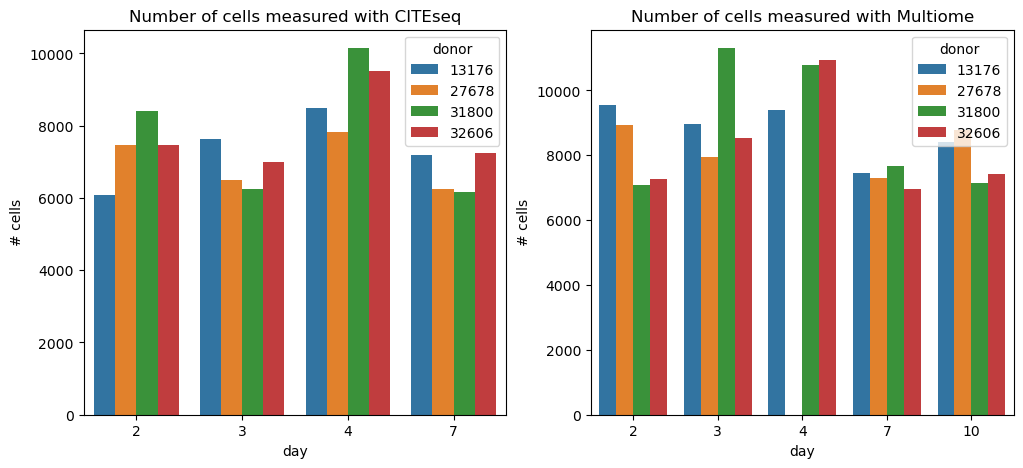

In [7]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
df_cite_cell_dist = df_cell_cite.set_index("cell_id")[["day","donor"]].value_counts().to_frame()\
                .sort_values("day").reset_index()\
                .rename(columns={0:"# cells"})
sns.barplot(data=df_cite_cell_dist, x="day",hue="donor",y="# cells", ax=axs[0])
axs[0].set_title("Number of cells measured with CITEseq")

df_multi_cell_dist = df_cell_multi.set_index("cell_id")[["day","donor"]].value_counts().to_frame()\
                .sort_values("day").reset_index()\
                .rename(columns={0:"# cells"})
sns.barplot(data=df_multi_cell_dist, x="day",hue="donor",y="# cells", ax=axs[1])
axs[1].set_title("Number of cells measured with Multiome")
plt.show()

### Cite-seq

In [8]:
# X (train+test): gene expression

START = 0
STOP = START + 1000

df_cite_train_x = pd.read_hdf(CITE_TRAIN_INPUTS, start=START,stop=STOP)
df_cite_test_x = pd.read_hdf(CITE_TEST_INPUTS, start=START,stop=STOP)
print(df_cite_train_x.shape, df_cite_test_x.shape)

df_cite_train_x.head() # cell * gene (Ensembl ID)

(1000, 22050) (1000, 22050)


gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


In [9]:
# Y (train): protein
df_cite_train_y = pd.read_hdf(CITE_TRAIN_TARGETS, start=START, stop=STOP)
print(df_cite_train_y.shape)

df_cite_train_y.head() # cell * protein

(1000, 140)


gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445


In [10]:
# # train and test meta data

# train_cells = df_cite_train_x.index.to_list()    
# test_cells = df_cite_test_x.index.to_list()                                                     
# df_cell_cite["split"] = ""
# df_cell_cite.loc[df_cell_cite.cell_id.isin(train_cells),"split"] = "train"
# df_cell_cite.loc[df_cell_cite.cell_id.isin(test_cells),"split"] = "test"

# print(df_cell_cite["split"].value_counts())

# df_cell_cite

In [11]:
# # df_cell_cite.to_csv("df_cell_cite.csv")

# df_cell_cite = pd.read_csv("df_cell_cite.csv", index_col=0) # full meta data
# df_cell_cite.head() 

In [12]:
# df_cell_cite[["split","day","donor"]].value_counts().to_frame().sort_values(["split","day","donor"]).rename(columns={0: "n cells"})

In [13]:
def to_h5ad(df: pd.DataFrame, df_cell: pd.DataFrame,):
    ada = sc.AnnData(csr_matrix(df.to_numpy()))
    ada.var = pd.DataFrame(df.columns)
    ada.obs_names = df.index
    ada.var_names = ada.var['gene_id']
    ada.obs = pd.merge(ada.obs, df_cell, on=['cell_id']).set_index("cell_id")
    
    return ada

In [14]:
ada_train_x = to_h5ad(df_cite_train_x, df_cell_cite,)
ada_test_x = to_h5ad(df_cite_test_x, df_cell_cite,)
ada_train_y = to_h5ad(df_cite_train_y, df_cell_cite,)

print(ada_train_x.shape, ada_test_x.shape, ada_train_y.shape)

(1000, 22050) (1000, 22050) (1000, 140)


In [15]:
ada_train_x.obs["cell_type"].value_counts(), ada_train_x.obs["day"].value_counts() 

(HSC     451
 EryP    179
 NeuP    168
 MasP    110
 MkP      83
 BP        6
 MoP       3
 Name: cell_type, dtype: int64,
 2    1000
 Name: day, dtype: int64)

In [16]:
ada_train_x.write("../toy_data/cite_train_x.h5ad")
ada_test_x.write("../toy_data/cite_test_x.h5ad")
ada_train_y.write("../toy_data/cite_train_y.h5ad")

In [17]:
# ada_x = sc.AnnData(csr_matrix(df_cite_test_x.to_numpy()))
# ada_x

In [18]:
# # ada_train_x.obs = pd.DataFrame(df_cite_test_x.index)
# ada_x.var = pd.DataFrame(df_cite_test_x.columns)
# ada_x.obs_names = df_cite_test_x.index
# ada_x.var_names = ada_x.var['gene_id']

# ada_x

In [19]:
# df = pd.merge(ada_x.obs, df_cell_cite.set_index('cell_id'), 
#          on='cell_id')#.set_index("cell_id")
# # ada_x.obs = df

# # ada_x
# df

### Multiome

In [20]:
df_multi_train_x = pd.read_hdf(MULTIOME_TRAIN_INPUTS,start=START,stop=STOP)
df_multi_test_x = pd.read_hdf(MULTIOME_TEST_INPUTS,start=START,stop=STOP)
df_multi_train_x.head()

gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
56390cf1b95e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.428336,0.0,0.0,0.0,0.0
fc0c60183c33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9b4a87e22ad0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
81cccad8cd81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15cb3d85c232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [21]:
df_multi_test_x.head()

gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
458c2ae2c9b1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01a0659b0710,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
028a8bc3f2ba,0.0,0.0,0.0,0.0,0.0,0.0,2.951019,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7ec0ca8bb863,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
caa0b0022cdc,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df_multi_train_y = pd.read_hdf(MULTIOME_TRAIN_TARGETS, start=START, stop=STOP)
df_multi_train_y.head()

gene_id,ENSG00000121410,ENSG00000268895,ENSG00000175899,ENSG00000245105,ENSG00000166535,ENSG00000256661,ENSG00000184389,ENSG00000128274,ENSG00000094914,ENSG00000081760,...,ENSG00000086827,ENSG00000174442,ENSG00000122952,ENSG00000198205,ENSG00000198455,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755
cell_id,,,,,,,,,,,,,,,,,,,,,
56390cf1b95e,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,4.893861,0.0,0.0,0.000000,0.0,5.583255,0.000000,4.893861
fc0c60183c33,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
9b4a87e22ad0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,5.107832,0.0,0.0,0.000000,0.0,0.000000,0.000000,5.107832
81cccad8cd81,0.0,4.507936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.195558,4.507936,0.0,0.0,0.000000,0.0,0.000000,0.000000,5.195558
15cb3d85c232,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,5.531572,0.0,0.000000,4.842377,0.000000


In [23]:
ada_train_x = to_h5ad(df_multi_train_x, df_cell_multi,)
ada_test_x = to_h5ad(df_multi_test_x, df_cell_multi,)
ada_train_y = to_h5ad(df_multi_train_y, df_cell_multi,)

print(ada_train_x.shape, ada_test_x.shape, ada_train_y.shape)

(1000, 228942) (1000, 228942) (1000, 23418)


In [24]:
ada_train_x.write("../toy_data/multi_train_x.h5ad")
ada_test_x.write("../toy_data/multi_test_x.h5ad")
ada_train_y.write("../toy_data/multi_train_y.h5ad")